## Importing libraries

In [1]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

## Data preprocessing

In [2]:
# load data from JSON file
with open('../data/raw/intents.json') as file:
    data = json.load(file)

# extract text and intent from data
texts = []
intents = []
for intent in data['intents']:
    for text in intent['text']:
        texts.append(text)
        intents.append(intent['intent'])

# tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
encoded_texts = tokenizer.texts_to_sequences(texts)

# pad sequences to have equal length
max_len = max([len(x) for x in encoded_texts])
padded_texts = pad_sequences(encoded_texts, maxlen=max_len, padding='post')

In [3]:
# save tokenizer
import pickle

with open('../models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# create label encoder object
# Create and fit the LabelEncoder
le = LabelEncoder()
le.fit(intents)  # intents is the list of all labels used for training

# Save the fitted LabelEncoder
with open('../models/label_encoder.pickle', 'wb') as le_file:
    pickle.dump(le, le_file)

# fit and transform the intents to integer labels
encoded_intents = le.fit_transform(intents)

# get the number of unique labels
num_intents = len(le.classes_)

# apply one-hot encoding to the integer labels
encoded_intents = tf.one_hot(encoded_intents, depth=num_intents)

## Model

In [ ]:
# define model architecture
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_len)(input_layer)
lstm_layer = LSTM(128)(embedding_layer)
output_layer = Dense(num_intents, activation='softmax')(lstm_layer)
model = Model(inputs=input_layer, outputs=output_layer)

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model.fit(padded_texts, encoded_intents, epochs=50, batch_size=16)

# save model
model.save('../models/chatbot_model34.keras')

Epoch 1/50


/Users/amilbek/miniforge3/envs/trends-of-ai-semester-project/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0437 - loss: 3.6421
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0659 - loss: 3.5129
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0712 - loss: 3.4124 
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1566 - loss: 2.9371
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2115 - loss: 2.6681
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3518 - loss: 2.2299
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4153 - loss: 1.9237
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4875 - loss: 1.6541
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5813 - loss: 1.4769
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6298 - loss: 1.2006
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7018 - loss: 1.0597
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7803 - loss: 0.8011

## Evaluation

In [4]:
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

model = load_model('../models/chatbot_model34.keras')

# Split data
texts_train, texts_test, intents_train, intents_test = train_test_split(
    padded_texts, encoded_intents.numpy(), test_size=0.2, random_state=42
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(texts_test, intents_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8992 - loss: 0.3037
Test Loss: 0.26425859332084656
Test Accuracy: 0.9156626462936401


In [5]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on test data
predictions = model.predict(texts_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(intents_test, axis=1)

# Unique true classes in the test set
unique_test_classes = np.unique(true_classes)

# Classes in the label encoder
all_classes = np.arange(len(le.classes_))

# Check for missing classes
missing_classes = set(all_classes) - set(unique_test_classes)
print(f"Missing classes in test set: {missing_classes}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Missing classes in test set: {34, 11, 16, 19, 27, 29}


In [7]:
# Classification report
from sklearn.metrics import classification_report

report = classification_report(
    true_classes,
    predicted_classes,
    labels=all_classes,
    target_names=le.classes_,
    zero_division=0  # Handle missing classes gracefully
)
print(report)

                precision    recall  f1-score   support

Mess Timetable       0.80      1.00      0.89         4
     admission       1.00      1.00      1.00         3
       canteen       1.00      1.00      1.00         1
college intake       1.00      1.00      1.00         2
     committee       1.00      1.00      1.00         1
   computerhod       1.00      1.00      1.00         1
        course       1.00      1.00      1.00         5
       creator       1.00      1.00      1.00         6
      document       1.00      1.00      1.00         3
         event       1.00      1.00      1.00         2
       extchod       1.00      1.00      1.00         1
    facilities       0.00      0.00      0.00         0
          fees       1.00      0.67      0.80         3
        floors       1.00      1.00      1.00         2
       goodbye       1.00      1.00      1.00         2
      greeting       0.00      0.00      0.00         2
           hod       0.00      0.00      0.00  

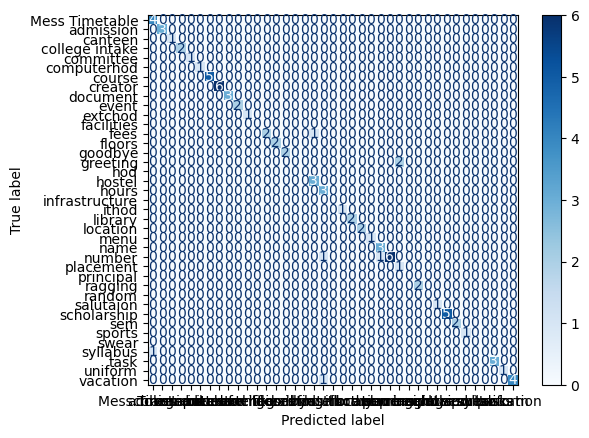

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(true_classes, predicted_classes, labels=all_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.show()

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9592 - loss: 0.1169 - val_accuracy: 0.9157 - val_loss: 0.1904
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9901 - loss: 0.0592 - val_accuracy: 0.9277 - val_loss: 0.2601
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9965 - loss: 0.0266 - val_accuracy: 0.8795 - val_loss: 0.3291
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0153 - val_accuracy: 0.8434 - val_loss: 0.3738
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9954 - loss: 0.0147 - val_accuracy: 0.8434 - val_loss: 0.3959
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9985 - loss: 0.0111 - val_accuracy: 0.8554 - val_loss: 0.3996
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9985 - loss: 0.0087 - val_accuracy: 0.8795 - val_loss: 0.4017
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0089 - val_accuracy: 0.8795 - val_loss:

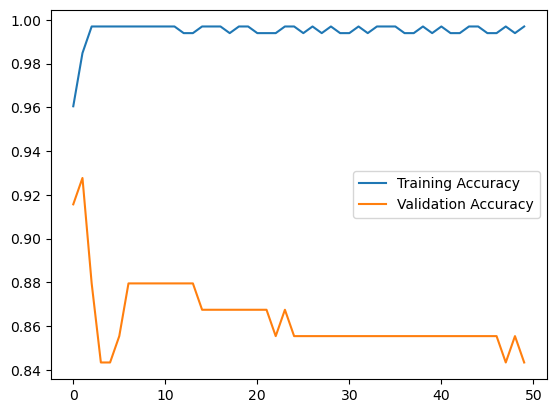

In [9]:
history = model.fit(
    padded_texts,
    encoded_intents,
    validation_split=0.2,
    epochs=50,
    batch_size=16
)

# Plot training and validation metrics
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [10]:
import time

# Measure throughput
start_time = time.time()
_ = model.predict(texts_test)
end_time = time.time()

throughput = len(texts_test) / (end_time - start_time)
print(f"Throughput: {throughput:.2f} predictions/second")

# Measure latency
start_time = time.time()
_ = model.predict(texts_test[:1])
end_time = time.time()

latency = (end_time - start_time) * 1000  # Convert to milliseconds
print(f"Latency: {latency:.2f} ms/prediction")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Throughput: 1669.05 predictions/second
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Latency: 33.24 ms/prediction


In [11]:
import os

model_size = os.path.getsize('../models/chatbot_model34.keras') / (1024 * 1024)  # Size in MB
print(f"Model size: {model_size:.2f} MB")

Model size: 2.01 MB
